# Credit Card Fraud Detection project

##### Objective :
The objective of this project is classification of transactions out of a dataset containing genuine and fraud transactions. 
The emphasis would be on correctly identifying the fraud transactions as this is relatively more critical to banking business than misidentifying genuine transactions.     

##### Challenges :  
1) Fraud transactions make up only 0.17% of the total transactions in the dataset. This can severely hamper the learning ability of classification models.  
2) Features are all PCA transformed (except Time, Amount and Class).  

##### Methodology :
I have used resampling to run 3 variations :  
a) Undersampling majority class to match minority class by 100%  
b) Oversampling minority class to 5% of majority class and then equating both classes.  
c) Oversampling minority class to 20% of majority class and then equating both classes.  
I have then finalized a dataset based on the third variation (20% of majority class) based on a combination of F1 score and Recall. The finalized dataset and model is fed into Sagemaker, trained and deployed as a serverless inference endpoint.
This variation was chosen because it met evaluation criteria. 

##### Project Flow :  
A) DATA OVERVIEW  
    ---Initial data checks  
    ---Charts visualization  
B) FEATURE ENGINEERING  
    ---Outliers  
    ---Time feature adjustment  
    ---Correlation  
    ---Duplicated rows  
    ---Train test Split  
    ---Scaling  
C) TRAINING VARIATIONS  
    ---Splits for training  
    --------Training for Variation 1  
    --------Results  
    --------Training for Variation 2  
    --------Results  
    --------Training for Variation 3  
    --------Results  
D) FEATURE IMPORTANCE  
E) SAGEMAKER   
    --------Uploading files  
    --------Training with Random Forest and results  
    --------Prediction input file setup  
    --------Model deployment setup  
    --------Serverless inference endpoint  
    --------Cleanup

## Initial data checks

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_predict,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import pandas as pd

%matplotlib inline

df = pd.read_csv("creditcard.csv")

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### - Except Amount and Time, all features are PCA transformed

In [3]:
# Checking info, no nulls were found 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Chart visualization

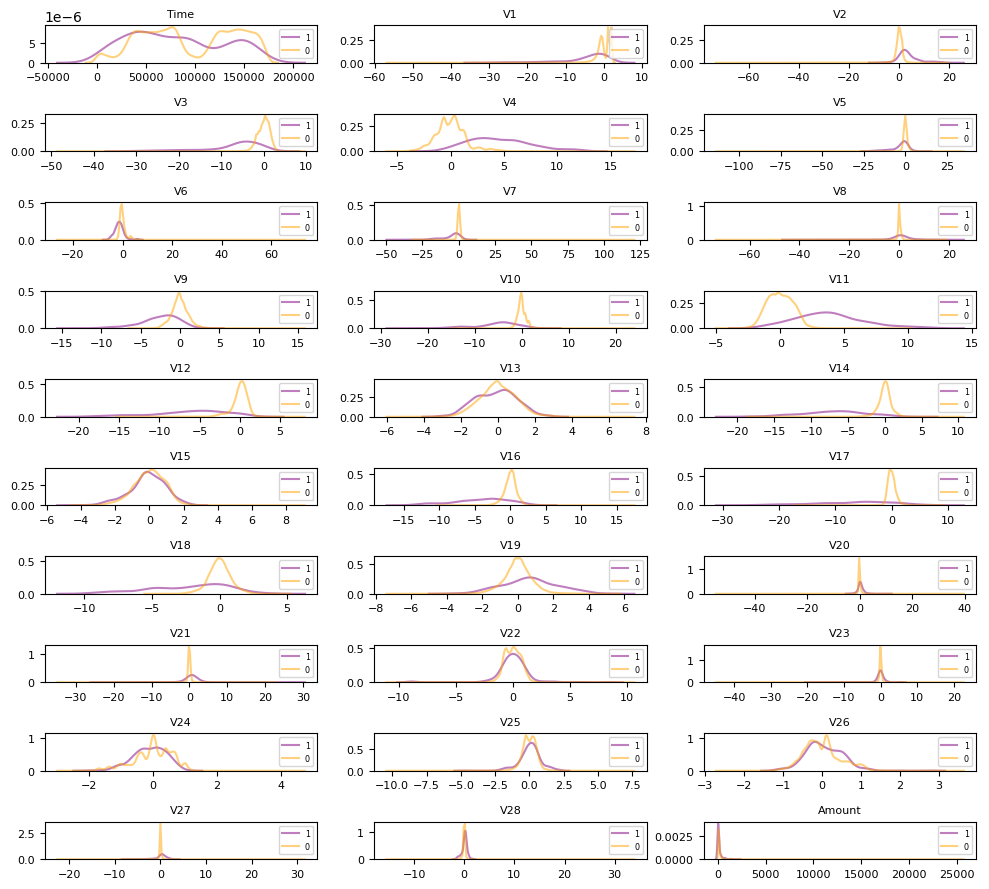

In [4]:
dfcol = [i for i in df.columns if i not in ["Class"]]

fig, axes = plt.subplots(10, 3, figsize=(10, 9))

axes = axes.flatten()

for i, col in enumerate(dfcol):
    sns.kdeplot(df[df['Class'] == 1][col], shade=False, label="1", ax=axes[i], color='purple', alpha=0.5)
    sns.kdeplot(df[df['Class'] == 0][col], shade=False , label="0", ax=axes[i], color='orange', alpha=0.5)
    axes[i].set_title(col, fontsize = 8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', labelsize=8)
    axes[i].legend(loc='upper right', fontsize='xx-small')
    plt.set_loglevel('WARNING')
    
plt.tight_layout()
plt.show()

#### - All features have already undergone PCA and labels are hidden for ethical purposes. 
#### - Fraud datapoints have a more uniform spread relatively vs non frauds. Especially for the time feature.  
#### - Time and Amount need to be scaled to prevent impact on learning for non-tree models. Tree-models are not sensitive to scaling. 

In [5]:
#checking count of items in Class
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

#### -Dataset is highly imbalanced.
#### -Resampling techniques like SMOTE and Undersampling will have to be used ahead.

## Outliers

In [6]:
#Creating copy df to drop outliers for checking
dfcopy = df.copy()

In [7]:
outliers_list = []
outliers_count = {}

In [9]:
#defining outliers with factor 3 instead of 1.5, for extreme outliers 
cols = [i for i in dfcopy.columns if i != "Class"]
for i in cols:
    Q1 = dfcopy[i].quantile(0.25)
    Q3 = dfcopy[i].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (3 * IQR)
    upper_bound = Q3 + (3 * IQR)
    
    outliers = dfcopy[(dfcopy[i] < lower_bound) | (dfcopy[i] > upper_bound)]
    outliers_list.extend(outliers.index.tolist()) 
    outliers_count[i] = len(outliers)

In [10]:
#list of outliers in each feature
print(outliers_count)

{'Time': 0, 'V1': 1994, 'V2': 4453, 'V3': 762, 'V4': 479, 'V5': 2321, 'V6': 5389, 'V7': 3051, 'V8': 11285, 'V9': 1077, 'V10': 3208, 'V11': 154, 'V12': 1305, 'V13': 2, 'V14': 2405, 'V15': 18, 'V16': 588, 'V17': 1449, 'V18': 283, 'V19': 628, 'V20': 13385, 'V21': 6934, 'V22': 193, 'V23': 8135, 'V24': 137, 'V25': 452, 'V26': 514, 'V27': 16524, 'V28': 12573, 'Amount': 18941}


In [11]:
#removing duplicated items by set conversion
outliers_list = list(set(outliers_list))

In [12]:
dfcopy = dfcopy.drop(index=outliers_list)

In [13]:
# Before dropping outliers
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [14]:
# After dropping outliers
dfcopy["Class"].value_counts()

Class
0    231431
1        40
Name: count, dtype: int64

#### - Outliers have not been dropped from main dataset because a lot of rows (containing a lot of imbalanced Frauds) have been classified as outliers.
#### - Loss of Fraud classes have to be minimized due to a minimal limited number for model to train on.

## Time feature adjustment

#### Conversion code below was added later in the final, I have not included the hours/minutes conversion but went with just scaling the column as seconds as per original. This is because there was no improvement in scores with the converted Time feature in trial runs and it was ranked at the bottom in random forest feature importance, indicating it is not contributing much to the model's pattern learning.  Code below :

In [ ]:
# NOT USED 
timedelta = pd.to_timedelta(d['Time'], unit='s')
df["Minutes"] = (timedelta.dt.components.minutes).astype(int) #Minute conversion
df["Hours"] = (timedelta.dt.components.hours).astype(int) #Hour conversion
df = df.drop(columns = ["Time"])

## Correlation

#### - Most columns do not seem to be correlated , this could be because this is a PCA transformed dataset. There are features that are slightly negatively correlated with target "Class".

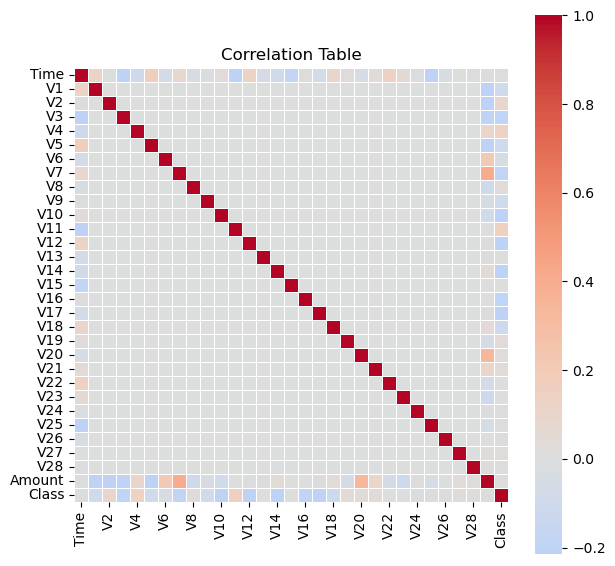

In [15]:
plt.figure(figsize = (7,7))
corr = df.corr()
sns.heatmap(corr, robust = True, center = 0,square = True, cmap="coolwarm",linewidths = .6)
plt.title('Correlation Table')
plt.show()

## Duplicate rows

#### - Checking for duplicate rows 
#### - 19 Frauds were also dropped but this will not affect learning as they were duplicates. 

In [16]:
duplicates = df.duplicated().sum()
duplicates

np.int64(1081)

In [17]:
duplicate_rows = df[df.duplicated()]

In [18]:
duplicate_rows["Class"].value_counts()

Class
0    1062
1      19
Name: count, dtype: int64

In [19]:
df = df.drop_duplicates()

## Train Test split 

In [20]:
# Using a 80 : 20 split for train and test set
trainX, testX = train_test_split(df, test_size=0.2, random_state=28)

In [21]:
trainX.reset_index(drop=True, inplace=True)
testX.reset_index(drop=True, inplace=True)

## Scaler

#### - I have scaled only Amount and Time columns. 
#### - RobustScaler is used to scale columns, it is not sensitive to outliers and skewed distributions.
#### - It uses the data point's difference from median and IQR division to scale features.

In [22]:
scaler = RobustScaler() 

In [23]:
#Scaling Train set
scaledtrain = scaler.fit_transform(trainX[["Amount", "Time"]])

In [24]:
scaledtrain_columns = pd.DataFrame(scaledtrain, columns = ["Amount", "Time"]) 

In [25]:
trainX[["Amount", "Time"]] = scaledtrain_columns

In [26]:
#Scaling Test set seperately to avoid data leakage
scaledtest = scaler.transform(testX[["Amount", "Time"]])

In [27]:
scaledtest_columns = pd.DataFrame(scaledtest, columns = ["Amount", "Time"])

In [28]:
testX[["Amount", "Time"]] = scaledtest_columns

## Train and Test splits

In [ ]:
#Seperating X and Y columns from train and test
#Making copies of train and test to run on resampled data for 3 variations. 

In [29]:
#For variation 1
trainY1 = trainX["Class"]
trainX1 = trainX.drop(columns=["Class"])
testY1 = testX["Class"]
testX1 = testX.drop(columns=["Class"])

In [ ]:
#For variation 2

In [30]:
trainX2 = trainX1.copy()

In [31]:
trainY2 = trainY1.copy()

In [32]:
testX2 = testX1.copy()

In [33]:
testY2 = testY1.copy()

In [ ]:
#For variation 3

In [34]:
trainX3 = trainX1.copy()

In [35]:
trainY3 = trainY1.copy()

In [36]:
testX3 = testX1.copy()

In [37]:
testY3 = testY1.copy()

#### - Training dataset will be sampled in 3 variations below, while Testing data will remain unchanged 

In [38]:
# Checking the value count of training set to ensure we have a substantial number of Fraud classes. 387 frauds. 82% of total frauds.
class_1s_train = trainY1.value_counts()
print(class_1s_train)

Class
0    226593
1       387
Name: count, dtype: int64


In [39]:
# Checking Test set, 86 frauds. 18% of total frauds.
class_1s_test = testY1.value_counts()
print(class_1s_test)

Class
0    56660
1       86
Name: count, dtype: int64


## Evaluating Imbalanced datasets -----------------------------------------------
#### - Accuracy is not a good indicator in imbalanced datasets due to the large number of majority class being identified correctly to drive the accuracy up. F1 score and recall are better metrics for evaluation.
#### 1) RECALL ----- Recall for the fraud class is the percentage of the correctly identified fraud classes among all the actual fraud classes. (i.e. how many fraud classes were correctly identified)
#### Recall, which drops as the False Negatives increase, is the chosen metric when dealing with datasets like fraud and heart disease, because it is in the best interest of the client to ensure fraud transactions are not mistakenly classifed as genuine transactions, which would cause more issues than genuine transactions being mistakenly classified as fraud.  But a balance is necessary.
#### 2) PRECISION ----- Precision for the fraud class is the percentage of the correctly identified fraud classes among  all the classes identified as fraud. (i.e. how many identified as fraud were actually fraud)
#### 3) F1_SCORE ----- F1 score is the harmonic mean of Precision and Recall. It includes both metric into its formula and rates the ability of the model to identify both classes.
#### - Higher the ROC AUC score out of 100, indicates the model's ability to differentiate both classes. (ROC AUC is used later in Sagemaker training)
 

## Models used ---------------------------------------------------------------------------
#### 1)XGB Classifier ----- Builds an ensemble of decision trees , where each new tree corrects the errors made by the previous trees. Weak learning trees are combined to make a strong learner.
#### 2)Random Forest Classifier ----- Builds multiple decision trees and outputs the most frequent class out of all the predictions by individual trees.
#### 3)Logistic Regression ----- Uses the logistic sigmoid curve to classify both classes. 
#### 4)SVC ----- Identifies a hyperplane that maximizes the margin (i.e. the distance from the nearest data point of either class to the hyperplane ) to separate both classes.

#### Key hyperparameters used were :
#### 1) Max depth (to control how deep the tree could grow in terms of split). Limiting the max depth reduced overfitting and reducing it too low made the model training poor. These were used for Random Forest and XGB Classifiers.  
#### 2) Gamma for XGB, increasing the Gamma reduced overfitting. (Gamma decides to make a split on a leaf node or not, based on loss reduction)


## Training 1: ---------------------------------------------------------------------------
## Undersampling majority class 100% (Fraud : 387 , Genuine : 387)

In [40]:
models = {
    'XGBoost': XGBClassifier(max_depth = 5, min_child_weight =2, gamma = 2),
    'Random Forest': RandomForestClassifier( max_depth = 5),
    "Logistic Regression" : LogisticRegression(),
    "SVC" : SVC()}

In [41]:
#Kfold set to 5 to ensure model does 4 train folds and one test fold selected at random 
kf = KFold(n_splits=5, shuffle=True, random_state=28)

#### - Default parameters set for all models except XGBoost and Random Forest.
#### - Parameters set are mainly to control overfitting. 

In [42]:
# Using Random Undersampler to match minority class 
undersample = RandomUnderSampler(sampling_strategy=1,  random_state=28)
trainX1, trainY1 = undersample.fit_resample(trainX1,trainY1)

In [43]:
trainY1.value_counts()

Class
0    387
1    387
Name: count, dtype: int64

In [44]:
accuracy_results1 = {}
training_accuracy_results1 = {}
classification_reports1 = {}

In [45]:
#Running the models, and appending the result metrics into defined dictionaries
for i,j in models.items():
    cv_model = cross_val_predict(j, trainX1, trainY1, cv=kf)
    j.fit(trainX1, trainY1)
    y_pred1 = j.predict(testX1)
    y_trainpred1 = j.predict(trainX1)
    
    
    trainaccuracy = accuracy_score(trainY1, y_trainpred1)
    training_accuracy_results1[i] = trainaccuracy
    
    accuracy = accuracy_score(testY1, y_pred1)
    accuracy_results1[i] = accuracy
    
    report = classification_report(testY1, y_pred1)
    classification_reports1[i] = report
    

In [46]:
for i, j in accuracy_results1.items():
    print(f"{i} training accuracy:  {round(training_accuracy_results1[i],4)}")  
    print(f"{i} testing accuracy: {round(j,4)}")
    print(f"{i} Classification:\n", classification_reports1[i])
    print("*******************************************************************")

XGBoost training accuracy:  0.9832
XGBoost testing accuracy: 0.9654
XGBoost Classification:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56660
           1       0.04      0.88      0.07        86

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.53     56746
weighted avg       1.00      0.97      0.98     56746

*******************************************************************
Random Forest training accuracy:  0.9599
Random Forest testing accuracy: 0.9865
Random Forest Classification:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56660
           1       0.09      0.84      0.16        86

    accuracy                           0.99     56746
   macro avg       0.54      0.91      0.58     56746
weighted avg       1.00      0.99      0.99     56746

*******************************************************************
Logist

## Results :
#### - For XGB : Recall for "fraud" is 88%, while precision is 4%
#### - For RFC : Recall for "fraud" is 84%, while precision is 9%
#### - For LogR : Recall for "fraud" is 88%, while precision is 4%
#### - For SVC : Recall for "fraud" is 83%, while precision is 8%
#### ---------------------------------------------------------------------------------------

#### - F1 score for fraud is highest in Random Forest.
#### - Logistic Regression and XGB  have scored better at Recall than Random Forest.
#### - Overall precision scores for fraud are very poor across models indicating all models have classified lots of genuine transactions as fraud.
#### - This could be because of massive undersampling with the model unable to learn trends of genuine transactions.
#### ---------------------------------------------------------------------------------------

## Training 2: ---------------------------------------------------------------------------
## Oversampling minority class to 5% of majority and equating both classes (Fraud : 11329, Genuine : 11329)

In [47]:
#Adjusting XGBoost and Random Forest hyperparameters because they tend to overfit.
model_2 = {
    'XGBoost': XGBClassifier(max_depth = 4, min_child_weight =2, gamma = 3),
    'Random Forest': RandomForestClassifier( max_depth = 8),
    "Logistic Regression" : LogisticRegression(),
    "SVC" : SVC()}

In [48]:
kf = KFold(n_splits=5, shuffle=True, random_state=28)

In [49]:
Smote = SMOTE(sampling_strategy = 0.05, random_state=28)
trainX2, trainY2 = Smote.fit_resample(trainX2, trainY2)

In [50]:
undersample = RandomUnderSampler(sampling_strategy=1, random_state=28)
trainX2, trainY2 = undersample.fit_resample(trainX2,trainY2)

In [51]:
trainY2.value_counts()

Class
0    11329
1    11329
Name: count, dtype: int64

In [52]:
accuracy_results2 = {}
training_accuracy_results2 = {}
classification_reports2 = {}

In [53]:
for i,j in model_2.items():
    cv_model = cross_val_predict(j, trainX2, trainY2, cv=kf)
    j.fit(trainX2, trainY2)
    y_pred2 = j.predict(testX2)
    y_trainpred2 = j.predict(trainX2)

    
    trainaccuracy = accuracy_score(trainY2, y_trainpred2)
    training_accuracy_results2[i] = trainaccuracy
    
    accuracy = accuracy_score(testY2, y_pred2)
    accuracy_results2[i] = accuracy
    
    report = classification_report(testY2, y_pred2)
    classification_reports2[i] = report


In [54]:
for i, j in accuracy_results2.items():
    print(f"{i} training accuracy:  {round(training_accuracy_results2[i],4)}")
    print(f"{i} testing accuracy: {round(j,4)}")
    print(f"{i} Classification:\n", classification_reports2[i])
    print("*******************************************************************")

XGBoost training accuracy:  0.9984
XGBoost testing accuracy: 0.9938
XGBoost Classification:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56660
           1       0.17      0.83      0.29        86

    accuracy                           0.99     56746
   macro avg       0.59      0.91      0.64     56746
weighted avg       1.00      0.99      1.00     56746

*******************************************************************
Random Forest training accuracy:  0.9729
Random Forest testing accuracy: 0.9973
Random Forest Classification:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56660
           1       0.33      0.81      0.47        86

    accuracy                           1.00     56746
   macro avg       0.67      0.91      0.74     56746
weighted avg       1.00      1.00      1.00     56746

*******************************************************************
Logist

## Results:
#### - For XGB : Recall for "fraud" is 83%, while precision is 17%
#### - For RFC : Recall for "fraud" is 81%, while precision is 33%
#### - For LogR : Recall for "fraud" is 88%, while precision is 6%
#### - For SVC : Recall for "fraud" is 86%, while precision is 11%
#### ---------------------------------------------------------------------------------------
#### - F1 score with a larger sample has improved, especially for both tree based models.
#### - Precision is still low, with only Random Forest performing relatively better than other models in not classifying genuine classes as fraud.
#### - Changing the hyperparameters did not increase scores much.
#### ---------------------------------------------------------------------------------------

## Training 3 : ---------------------------------------------------------------------------
## Oversampling minority class to 20% of majority and equating both classes (Fraud : 45318, Genuine : 45318)

In [55]:
models3 = {
    'XGBoost': XGBClassifier(max_depth = 5, min_child_weight =5, gamma = 4), #dropping max depth any lower decreases learning capacity f1 score, reducing gamma causes 100% training accuracy (overfitting while test f1 scores remain low) 
    'Random Forest': RandomForestClassifier( max_depth = 10),
    "Logistic Regression" : LogisticRegression(),
    "SVC" : SVC()}

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=28)

In [57]:
Smote = SMOTE(sampling_strategy = 0.2, random_state=28)
trainX3, trainY3 = Smote.fit_resample(trainX3, trainY3)

In [58]:
undersample = RandomUnderSampler(sampling_strategy=1, random_state=28)
trainX3, trainY3 = undersample.fit_resample(trainX3,trainY3)

In [59]:
trainY3.value_counts()

Class
0    45318
1    45318
Name: count, dtype: int64

In [60]:
accuracy_results3 = {}
training_accuracy_results3 = {}
classification_reports3 = {}

In [61]:
for i,j in models3.items():
    cv_model = cross_val_predict(j, trainX3, trainY3, cv=kf)
    j.fit(trainX3, trainY3)
    y_pred3 = j.predict(testX3)
    y_trainpred3 = j.predict(trainX3)
    
    trainaccuracy = accuracy_score(trainY3, y_trainpred3)
    training_accuracy_results3[i] = trainaccuracy
    
    accuracy = accuracy_score(testY3, y_pred3)
    accuracy_results3[i] = accuracy
    
    report = classification_report(testY3, y_pred3)
    classification_reports3[i] = report
    
    

In [62]:
for i, j in accuracy_results3.items():
    print(f"{i} training accuracy:  {round(training_accuracy_results3[i],4)}")
    print(f"{i} testing accuracy: {round(j,4)}")
    print(f"{i} Classification:\n", classification_reports3[i])
    print("*******************************************************************")

XGBoost training accuracy:  0.9994
XGBoost testing accuracy: 0.9974
XGBoost Classification:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56660
           1       0.35      0.84      0.49        86

    accuracy                           1.00     56746
   macro avg       0.67      0.92      0.75     56746
weighted avg       1.00      1.00      1.00     56746

*******************************************************************
Random Forest training accuracy:  0.9889
Random Forest testing accuracy: 0.9986
Random Forest Classification:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56660
           1       0.53      0.80      0.64        86

    accuracy                           1.00     56746
   macro avg       0.77      0.90      0.82     56746
weighted avg       1.00      1.00      1.00     56746

*******************************************************************
Logist

## Results:
#### - For XGB : Recall for "fraud" is 84%, while precision is 35%
#### - For RFC : Recall for "fraud" is 80%, while precision is 53%
#### - For LogR : Recall for "fraud" is 88%, while precision is 6%
#### - For SVC : Recall for "fraud" is 87%, while precision is 10%
#### ---------------------------------------------------------------------------------------
#### - All models have maintained  good recall scores across all samples of training .  
#### - As sample size increased, the Precision and F1 score also increased for Tree-based models.
#### - This variation was selected , because it achieved a 80% + in recall and a better Precision and F1 score than the previous 5% run. ( I attempted another run with 120,000 Genuine rows and 120,000 Frauds but the dataset overfit at 100% and precision scores improved slightly with more number of Genuine rows to learn from but Recall scores did not improve and dropped to below 80)
#### - A reason for Low precision scores could be the models fail to accurately classify fraud classes because of the overlap in the trends of the synthetic duplicated rows of SMOTE.
#### - This is a reason why heavy imbalance in datasets is generally not favoured.
#### - Confusion Matrix has been analyzed in Sagemaker.
#### ---------------------------------------------------------------------------------------

## Feature importance

#### V14 has contributed far ahead than other features with Amount and Time features contributing lesser than most others. 

In [63]:
# Getting the vital features for Random Forest model for the 3rd variation
importances = models['Random Forest'].feature_importances_
feature_names = trainX3.columns

In [64]:
feature_importance_df = pd.DataFrame({
    'Feature': trainX3.columns,
    'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

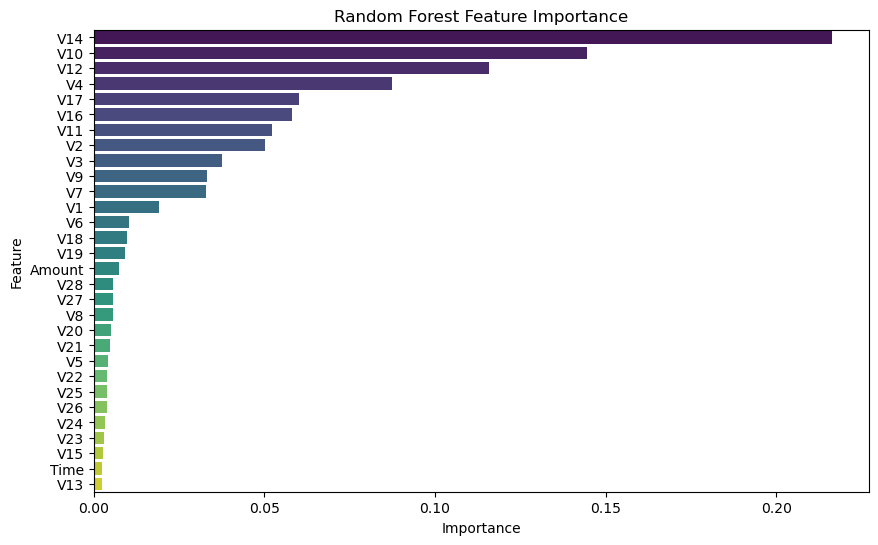

In [65]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

In [66]:
trainX3 = trainX3.reset_index(drop = True)
trainY3 = trainY3.reset_index(drop = True)

In [67]:
#Concatenate X and Y train to send to S3
train_dataset = pd.concat([trainX3, trainY3], axis=1)

In [68]:
testX3 = testX3.reset_index(drop = True)
testY3 = testY3.reset_index(drop = True)

In [69]:
#Concatenate X and Y test to send to S3
test_dataset = pd.concat([testX3, testY3], axis=1)

## Sagemaker

In [70]:
#Creating a Sagemaker session and bucket
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker-us-east-1-235494776661


In [71]:
bucket_name = "sagemaker-us-east-1-235494776661"

In [72]:
#Converting train and test to CSV format to send to S3 bucket 
train_dataset.to_csv ("trainX_pathcreditcard", index = False)
test_dataset.to_csv ("testX_pathcreditcard", index = False)

In [73]:
# Sending the files to S3
train_path = session.upload_data(path="trainX_pathcreditcard", bucket=bucket_name, key_prefix="sagemaker/creditcardfraud")
test_path = session.upload_data(path="testX_pathcreditcard", bucket=bucket_name, key_prefix="sagemaker/creditcardfraud")

print(f"Train path: {train_path}")
print(f"Test path: {test_path}")

Train path: s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/trainX_pathcreditcard
Test path: s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/testX_pathcreditcard


In [74]:
#Reading train and test CSVs from S3
trainX = pd.read_csv("s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/trainX_pathcreditcard")

testX = pd.read_csv("s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/testX_pathcreditcard")

print(trainX.shape)
trainX.head()

(90636, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.474800,1.246448,0.395872,0.303920,1.113172,-0.233193,-0.956060,0.243426,-0.254696,-0.075229,...,0.031128,0.157741,-0.103507,0.402899,0.701585,-0.329304,0.016397,0.021007,-0.256121,0
1,-0.196975,-0.816832,-0.317234,3.004232,-1.386360,-1.404141,0.608346,-0.898615,0.612256,0.446281,...,0.145450,0.735788,-0.348689,0.088558,0.411740,-0.076539,0.349478,0.122254,-0.222593,0
2,0.810182,2.259102,-1.471543,-0.971554,-1.766255,-1.011867,0.074752,-1.340102,0.046454,-1.329778,...,-0.129567,0.077760,0.233062,0.268212,-0.232346,-0.202859,0.013618,-0.053213,-0.013912,0
3,0.453680,-0.459123,1.371284,-0.834250,-0.309723,0.754764,-0.162928,0.474200,0.480741,-0.473647,...,-0.196330,-0.605959,0.130123,0.085267,-0.973899,0.186201,0.159823,0.227343,-0.180996,0
4,0.586813,2.043048,0.162998,-1.725068,0.529387,0.156958,-1.435864,0.234951,-0.345388,0.656055,...,0.196997,0.723357,-0.014780,-0.113849,0.225737,-0.095700,-0.002697,-0.032239,-0.208820,0


## Sagemaker Training file
#### Train.py file is used to define the loading , processing, model, model training, and evaluation steps

In [75]:
%%writefile train.py

import argparse
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score,confusion_matrix

model_file_name = "creditfraudpmc.joblib"

# Main function
def main():
    # Arguments
    parser = argparse.ArgumentParser()
    
    # Inbuilt Arguments: https://github.com/aws/sagemaker-containers#id11
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    
    # Custom Arguments
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--min_samples_split", type=int, default=2)
    parser.add_argument("--criterion", type=str, default="gini")
    parser.add_argument("--max_features", type=str, default="sqrt")
    parser.add_argument("--min_samples_leaf", type=int, default=2)
    parser.add_argument("--max_depth", type=int, default=10)
    
    
    args, _ = parser.parse_known_args()
    
    #DATA_LOAD
    trainX = pd.read_csv("s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/trainX_pathcreditcard")
    testX = pd.read_csv("s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/testX_pathcreditcard")

    #X&Y_SPLIT
    trainY = trainX["Class"]
    trainX = trainX.drop(columns=["Class"])
    testY = testX["Class"]
    testX = testX.drop(columns=["Class"])
    
    # Random Forest Model
    model = RandomForestClassifier(n_estimators=args.n_estimators, 
                                   min_samples_split=args.min_samples_split,
                                   criterion=args.criterion, 
                                   min_samples_leaf = args.min_samples_leaf,
                                   max_depth = args.max_depth, 
                                   max_features = args.max_features )
    
    # MODEL_FIT
    model.fit(trainX, trainY)

    # Training data accuracy
    train_accuracy = model.score(trainX, trainY)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Testing data accuracy
    test_accuracy = model.score(testX, testY)
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    
    # Classification_report
    y_pred = model.predict(testX)
    report = classification_report(testY, y_pred)
    print("Classification Report:\n", report)
    
    # ROC AUC score
    auc_score = roc_auc_score(testY, y_pred)
    print(f'AUC ROC Score: {auc_score:.2f}')
    
    #Confusion Matrix
    matrix = confusion_matrix(testY, y_pred)
    print('Confusion Matrix:\n', matrix)

    print(f"Shape of trainX: {trainX.shape}")
    print(f"Shape of trainY: {trainY.shape}")
    print(f"Shape of testX: {testX.shape}")
    print(f"Shape of testY: {testY.shape}")
    print("\nValue counts for trainY:")
    print(trainY.value_counts())
    print("\nValue counts for testY:")
    print(testY.value_counts())
    
    # Save the model
    model_save_path = os.path.join(args.model_dir, model_file_name)
    joblib.dump(model, model_save_path)
    print(f"Model saved at {model_save_path}")
    
    
# Run the main function when the script runs
if __name__ == "__main__":
    main()

Overwriting train.py


In [ ]:
# Requirements file, with botocore version edited due to version errors

In [76]:
%%writefile requirements.txt
pandas
scikit-learn
fsspec
s3fs
imbalanced-learn
botocore == 1.31.57

Overwriting requirements.txt


In [77]:
#Creating a execution role for running the model and specifying the hyperparameters
#Including Spot Instances = True to save training costs

from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

sklearn_estimator = SKLearn(
    base_job_name="creditfraud-check",
    framework_version="1.0-1",
    entry_point="train.py",
    dependencies=["requirements.txt"],
    hyperparameters={
        "n_estimators": 100,
        "min_samples_split": int(2),
        "min_samples_leaf":1,
        "max_depth": 10,
        "max_features": "sqrt",
        "criterion": "gini"},
    instance_count=1,
    instance_type="ml.m4.xlarge",
    use_spot_instances=True,
    max_wait=600,
    max_run=600,
    role=get_execution_role(),
)

# Launch Training job
sklearn_estimator.fit()

INFO:sagemaker:Creating training-job with name: creditfraud-check-2024-10-09-05-20-10-287


2024-10-09 05:20:11 Starting - Starting the training job...
2024-10-09 05:20:37 Starting - Preparing the instances for training......
2024-10-09 05:21:34 Downloading - Downloading the training image.........
2024-10-09 05:22:55 Training - Training image download completed. Training in progress.2024-10-09 05:23:03,670 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-09 05:23:03,674 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-09 05:23:03,677 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-10-09 05:23:03,695 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-09 05:23:03,949 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other 

#### - Out of all transactions classified as fraud, 80% are correctly identified. (69 out of 86) 
#### - This is a satisfactory working result, considering the imbalance in the original dataset and that most fraud rows in the training set were synthetic oversampled rows.
#### - F1 score is 63% which is an evaluation of how well the model identifies genuine vs fraud.
#### - Priority for a bank manager would be placed on the correctly identified fraud transactions more than the misidentified genuine transactions but it is also necessary to prevent too many genuine transactions as being misclassified as fraud. 

In [78]:
import boto3
sm_client = boto3.client("sagemaker")

training_job_name = sklearn_estimator.latest_training_job.name

#Location of the model training job from S3. This will be needed as input for model deployment code.
model_artifact = sm_client.describe_training_job(TrainingJobName=training_job_name)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Training job name: {training_job_name}")
print(f"Model storage location: {model_artifact}")

Training job name: creditfraud-check-2024-10-09-05-20-10-287
Model storage location: s3://sagemaker-us-east-1-235494776661/creditfraud-check-2024-10-09-05-20-10-287/output/model.tar.gz


## Hyperparameter tuning

#### - I have not used hyperparameter tuning within Sagemaker here, because evaluation was as per project expectations and tuning hyperparameters would not influence the results in the trials I ran. I have already used trial and error during the variation runs to train model multiple times.  

#### - Key hyperparameters used were max depth (to control how deep the tree could grow in terms of split). Limiting the max depth reduced overfitting and reducing it too low made the model training poor. These were used for Random Forest and XGB Classifiers.  

#### - For XGB in trials I also used Gamma, increasing the Gamma reduced overfitting. (Gamma decides to make a split on a leaf node or not, based on loss reduction)

#### - Code for Random Forest Classifier Hyperparameter Tuning has been left below for project scope and has not been used ...

In [ ]:
# NOT USED

import re
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter


hyperparameter_ranges = {
    "n_estimators": CategoricalParameter([80, 100]),
    "min_samples_split": CategoricalParameter([2, 4]),
    "min_samples_leaf": CategoricalParameter([2, 4]),
    }


optimizer = HyperparameterTuner(
    base_tuning_job_name="hyperparametercheck",
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type="Maximize",
    objective_metric_name="test-accuracy",
    metric_definitions=[
        {"Name": "train-accuracy", "Regex": "Training Accuracy: ([0-9.]+).*$"},
        {"Name": "test-accuracy", "Regex": "Testing Accuracy: ([0-9.]+).*$"}
    ],
    max_jobs=10,
    max_parallel_jobs=2,
)


optimizer.fit()

## Serve.py file
#### Serve.py file is needed to define functions to load the endpoint inputs as json files, process the file to match the input of the train set, make predictions on input and return the predictions as a json file. It is fed into the model deployment segment. 

In [79]:
%%writefile serve.py

import os
import joblib
import pandas as pd
import numpy as np

def model_fn(model_dir):
    model_file_name = "creditfraudpmc.joblib"
    pipeline_model = joblib.load(os.path.join(model_dir, model_file_name))
    
    return pipeline_model
      
def input_fn(request_body, request_content_type):
    if request_content_type == "application/json":
        input_object = pd.read_json(request_body, lines=True)
        
        #Only one preprocessing command entered to drop the target column from prediction dataset        
        def remove_target (db):
            db = db.drop(columns = ["Class"])
            return db
        
        input_object = remove_target (input_object)
        
        return input_object
    else:
        raise ValueError("Application/json content type only")        

def predict_fn(input_object, pipeline_model):
    predictions = pipeline_model.predict(input_object)
    pred_probs = pipeline_model.predict_proba(input_object)
    
    prediction_object = pd.DataFrame(
        {
            "prediction": predictions.tolist(),
            "pred_prob_class0": pred_probs[:, 0].tolist(),
            "pred_prob_class1": pred_probs[:, 1].tolist()
        }
    )
    
    return prediction_object

def output_fn(prediction_object, request_content_type):
    return_object = prediction_object.to_json(orient="records", lines=True)
    
    return return_object

Overwriting serve.py


In [80]:
%%writefile requirements.txt
pandas
numpy
scikit-learn

Overwriting requirements.txt


## Model Endpoint Deployment

In [81]:
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import Session, get_execution_role

session = Session()
bucket = session.default_bucket()

#Creating an endpoint and defining the training job as the model used to predict data requested by endpoint users  
training_job_name = "creditfraud-check-2024-10-09-05-20-10-287"
model_artifact = f"s3://{bucket}/{training_job_name}/output/model.tar.gz"
endpoint_name = "creditfraud"

model = SKLearnModel(
    name=endpoint_name,
    framework_version="1.0-1",
    entry_point="serve.py",
    dependencies=["requirements.txt"],
    model_data=model_artifact,
    role=get_execution_role(),
    sagemaker_session = session
)

## Serverless Endpoint

In [82]:
from sagemaker.serverless import ServerlessInferenceConfig

#Defining Serverless that can run 4 requests concurrently
serverless_config = ServerlessInferenceConfig(memory_size_in_mb=1024, 
                                              max_concurrency=4)

In [83]:
#Deploying the model at an endpoint 
predictor = model.deploy(serverless_inference_config=serverless_config)

INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker:Creating model with name: creditfraud
INFO:sagemaker:Creating endpoint-config with name creditfraud-2024-10-09-05-29-39-503
INFO:sagemaker:Creating endpoint with name creditfraud-2024-10-09-05-29-39-503


------!

In [84]:
# Endpoint name is needed to feed into the cleanup function 
endpoint_name = predictor.endpoint_name
print("Endpoint name:")
print(f"{endpoint_name}")

Endpoint name:
creditfraud-2024-10-09-05-29-39-503


## Checking the endpoint

In [85]:
# Loading sample data to predict
import pandas as pd

check_df = pd.read_csv("s3://sagemaker-us-east-1-235494776661/sagemaker/creditcardfraud/testX_pathcreditcard")
check_df_sample = check_df.sample(n=5)
X_pred = check_df_sample.to_json(orient="records", lines=True)

In [86]:
# Submit to the endpoint
import boto3

sm_runtime = boto3.client("sagemaker-runtime")

response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                      Body=X_pred, 
                                      ContentType="application/json", 
                                      Accept="application/json")

In [87]:
# Decode the response from the endpoint
response_body = response['Body']
response_str = response_body.read().decode('utf-8')
response_df = pd.read_json(response_str, lines=True)

In [88]:
#Predicted sample (ONLY FOR DEMONSTRATION)
response_df["prediction"]

0    0
1    0
2    0
3    0
4    0
Name: prediction, dtype: int64

In [89]:
#Original sample for comparison
check_df_sample["Class"]

3937     0
2462     0
26568    0
20068    0
4395     0
Name: Class, dtype: int64

## Cleanup 

In [90]:
import boto3

def cleanup(endpoint_name):
    sm_client = boto3.client("sagemaker")

    # Get the model name from endpoint_name
    response = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)

    # Delete the endpoint
    sm_client.delete_endpoint(EndpointName=endpoint_name)

    # Delete the endpoint config
    endpoint_config_name = response['EndpointConfigName']
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)                        

    # Delete the model
    model_name = response['ProductionVariants'][0]['ModelName']
    sm_client.delete_model(ModelName=model_name)

In [91]:
# Run the cleanup
cleanup("creditfraud-2024-10-09-05-29-39-503")